--- 
Project in Microeconometrics / OSE Data Science | Summer 2021, M.Sc. Economics, Bonn University | Timo Haupt

# Replication of "The Price of Forced Attendance" by S. Kapoor, M. Oosterveen and D. Webbink (2020)

---

## Notes before reading or running this notebook
---

* As the final project of the Data Science Course I replicated the paper "The Price of Forced Attendance" by Kapoor, Oosterveen and Webbink (Journal of Applied Econometrics, Volume 36, Issue 2, March 2020, pp. 209-227).
The pdf-file of this paper can be downloaded [here](https://onlinelibrary.wiley.com/doi/10.1002/jae.2781).


* Do-File (for Stata) and Online-Appendix can be found [here](http://qed.econ.queensu.ca/jae/datasets/kapoor001/).


* The Data Set has not been provided by the authors in the publication and is also not available otherwise on the internet. In order to receive the data I had to send a request to the authors and state my replication motivation. For data protection reasons the authors didn't provide me their complete data set. So, my replication is based on the data set the authors were able to provide me with. This replication data set can be found in the [data-folder](https://github.com/OpenSourceEconomics/ose-data-science-course-projeect-tihaup/tree/master/data). Since it still contains private information like grades about students and it had to be requested privately from the authors, I ask you to not further distribute the data set and only use it to run this notebook.


* Since NBViewer and Mybinder may struggle with displaying the imported images, it might be best to download the entire repository from Github. Otherwise, the images can be found in this [folder](https://github.com/OpenSourceEconomics/ose-data-science-course-projeect-tihaup/tree/master/files) on Github.


* Whenever I replicated tables and figures directly from the paper, this has been clearly marked as "replication". Therefore, I stuck with the labels of the original tables and figures from the paper, in order to simplify the comparison between my work and the author's. All other tables and figures represent my independent contribution to the paper and are labeled accordingly.


* Certain parts have been only possible to replicate using a robust regression discontinuity function, that hasn't been implemented in python yet. That's why I had to estimate some results in the "R_magic" notebook that can be found in the [cache-folder](https://github.com/OpenSourceEconomics/ose-data-science-course-projeect-tihaup/tree/master/cache). In order to get the Continuous Integration workflow running I had to import these results into the main notebook, since the Kernel had died multiple times otherwise. Therefore, if you want to run this notebook, you have to check the [R_magic notebook](https://github.com/OpenSourceEconomics/ose-data-science-course-projeect-tihaup/blob/master/cache/R_magic.ipynb) and load an R environment, where stated, accordingly. 

---

### Table of Content

1. [Introduction](#introduction)
2. [Data](#data)
    * [Data Description](#data1)
    * [Descriptive Statistics](#data2)
3. [Identification Strategy & Empirical Approach](#identification)
   * [Regression Discontinuity Design](#identification1)
   * [Discussion of continuity assumption](#identification2)  
   * [Mass Points](#identification3)  
4. [Replication of Baseline Results](#baseline)
   * [Average Treatment Effect Estimates](#baseline1)
   * [Heterogeneous Average Treatment Effect Estimates](#baseline2)
5. [Robustness Checks](#robustness)
   * [Comparison Abolition Cohort](#robustness1)
   * [Discussion of Mechanisms](#robustness2)
   * [Fake Cutoff Test](#fakecutoff) 
6. [Independent Contributions](#independent)
   * [Local Linear Regression Estimates](#contribution1)
   * [Local Polynomial Regression Estimates](#contribution2)
   * [Sensitivity Analysis of Bandwidth Choice](#contribution3)
6. [Conclusion](#conclusion)
7. [References](#references)

---

### Imported Libraries

In [1]:
import pandas as pd
import os                               
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from stargazer.stargazer import Stargazer
from scipy.stats import ttest_ind
from tabulate import tabulate
import statsmodels.formula.api as smf
import tzlocal
import warnings
warnings.filterwarnings('ignore')
import pickle as pkl


pd.options.display.float_format = "{:,.3f}".format

In [2]:
from auxiliary.auxiliary_attendance_datasets import *
from auxiliary.auxiliary_attendance_tables import *
from auxiliary.auxiliary_attendance_plots import *

# (1.) Introduction <a name="introduction"></a>


Kapoor et al. (2020) "estimate the causal effect on additional structure on academic performance" by taking advantage of a forced tutorial attendance policy in an undergraduate Economics program at a large university in the Netherlands. 
The policy made tutorial attendance compulsary throughout the second year of the program for those students that had a GPA below 7 in the first year. 
Since the treatment assignment was based on a sharp threshold (first-year GPA of 7), Kapoor et al. (2020) decided to estimate the treatment effect using a Regression Discontinuity Design. 
They "show that the policy increases student attendance but has no average effect on grades". Though, second-year courses differed in how above-7 (untreated) students had to attend the tutorials. There are three types of courses: 

* $voluntary$: above-7 students can choose to attend tutorials as they wish.

* $encouraged$: above-7 students were "strongly encouraged" to attend tutorials.

* $forced$: above-7 students had to attend tutorials and to hand in  assignments which contributed to their final grade.

One of the main findings of the paper is that the effect on grades within voluntary courses has been significantly negative. Kapoor et al. (2020) argue that the forced policy was expected to have a positive effect on grades, since it gives students additional structure in their academic life. But their findings "suggest that grades decrease in these [voluntary] courses because the policy prevented forced students from picking their desired mix of study inputs" and therefore imposing further constraints on their choices. 

In the next Chapter, I will describe the data set and give basic descriptives of the data around the cutoff. Chapter 3 will introduce the identification strategy of the Regression Discontinuity Design and the important continuity assumption will be discussed. The baseline results of the paper will be replicated in Chapter 4 and further robustness checks will be conducted in Chapter 5. In Chapter 6 I will provide some independent extensions to the paper and finally I will conclude this notebook in Chapter 7. 

# (2.) Data <a name="data"></a>

### Data Description <a name="data1"></a>

In order to receive the data set I had to get in contact with the authors and describe my research motivation of replicating their paper. They send me their data set, but unfortunately all the students' individual characteristics have not been made available. Therefore, I was only able to replicate the main findings of the paper where those characteristics have not been used as control variables. 

The running variable for the Regression Discontinuity Design is $firstyeargpa$ which assigns students into treatment ($treat = 1$) if their GPA was below 7. The $cohort$ variable indicates if the forced attendance policy has been active ($cohort \in [1,5]$) or if it has been abolished ($cohort = 6$). The attendance policies for above-7 students are represented in the variable $coursepolicy \in \{voluntary, encouraged, forced\}$. 
The main outcome variables are second-year grades ($grade$), respectively standardized second-year grades ($stdgrade$), tutorial attendance rate ($attendance$) and if a course has been passed ($passcourse = 1$). Note that the variables $firstyeargpa_centered$, $treat$ and $passcourse$ have been created by me.


**Variables included in the underlying data set:**

In [3]:
### Importing the Data Set
df = get_data()

In [4]:
get_variable_description(df)

Variable,Type,Description
studentid,float32,unique student identifier
cohort,int16,cohorts ranging from 2008 to 2014
coursepolicy,object,attendance policy for above-7 students
grade,float64,second-year grades
stdgrade,float32,second-year grades standardized
stdgradeabolition,float32,stdgrade of the abolition cohort
attendance,float32,attendance rate of tutorials
firstyeargpa,float32,first-year average grade
treat,int64,indicator if first-year gpa was below 7
firstyeargpa_centered,float32,first-year average grade centered around 7


### Basic Descriptives  <a name="data2"></a>

**Replication of Table 1**

Table 1 compares the basic statistics of students below and above a first-year GPA of 7. Since the forced attendance policy only affected those students below 7, these students represent the treatment group.
Eventhough we restrict the data within a bandwidth of 0.365 around the first-year GPA cutoff of 7, we can find some highly significant differences between the treatment and control group. First, those being treated got on average lower grades in the second year and even significantly lower grades, though being close to their peers above first-year GPA of 7. Second, those in the treatment group had an average tutorial attendance rate of 90% compared to 77% in the group not affected by the attendance policy. 
Furthermore, the comparison of all the student's individual characteristics, including distance to university, age, gender, etc. shows that there are no significant differences on observables. 

In [5]:
### Data Set restricted to optimal bandwidth

optimal_bandwidth = 0.365
df1 = get_truncated_data(df,optimal_bandwidth,1,"all courses")

In [6]:
get_table1(df1,0.365)

╒══════════════════════════════════╤════════════════╤═════════════╤══════════════╤═══════════╕
│ Variable   |   First-year GPA:   │  [6.635,7.0]   │ [7,7.365]   │ Difference   │ p-value   │
╞══════════════════════════════════╪════════════════╪═════════════╪══════════════╪═══════════╡
│ Course level (second year)       │                │             │              │           │
├──────────────────────────────────┼────────────────┼─────────────┼──────────────┼───────────┤
│ Grade                            │                │             │              │           │
├──────────────────────────────────┼────────────────┼─────────────┼──────────────┼───────────┤
│ mean                             │ 6.326          │ 6.806       │ 0.48         │ 0.0       │
├──────────────────────────────────┼────────────────┼─────────────┼──────────────┼───────────┤
│ standard deviation               │ 1.328          │ 1.19        │              │           │
├──────────────────────────────────┼──────────────

Restricting the data further by decreasing the bandwidth around the cutoff to 0.1 does not change a lot. The difference in grade means decreases as expected but stays highly significant. No change at all can be observed for the difference in tutorial attendance. 
This is a clear hint, that we have significant differences when crossing the cutoff at 7, even when being very close to it and thus indicating an effect on grades and attendance rate by the course policy. 

In [7]:
### Independent Extension: restrict data to bandwidth of 0.1:

df2 = get_truncated_data(df,0.1,1,"all courses")
get_table1(df2,0.1)

╒══════════════════════════════════╤══════════════╤═══════════╤══════════════╤═══════════╕
│ Variable   |   First-year GPA:   │  [6.9,7.0]   │ [7,7.1]   │ Difference   │ p-value   │
╞══════════════════════════════════╪══════════════╪═══════════╪══════════════╪═══════════╡
│ Course level (second year)       │              │           │              │           │
├──────────────────────────────────┼──────────────┼───────────┼──────────────┼───────────┤
│ Grade                            │              │           │              │           │
├──────────────────────────────────┼──────────────┼───────────┼──────────────┼───────────┤
│ mean                             │ 6.495        │ 6.715     │ 0.22         │ 0.002     │
├──────────────────────────────────┼──────────────┼───────────┼──────────────┼───────────┤
│ standard deviation               │ 1.251        │ 1.222     │              │           │
├──────────────────────────────────┼──────────────┼───────────┼──────────────┼───────────┤

# (3.) Identification Strategy and Empirical Approach  <a name="identification"></a>

### Regression Discontinuity Design  <a name="identification1"></a>

The method of Regression Discontinuity fits very well for this identification problem, since we have a clear threshold that determines the assignment of treatment. If a student has a GPA, an average grade, below 7 after the first year, he/she receives the treatment, that is attendance in tutorial sessions becomes compulsary. On the other hand, for above-7 students there are three different attendance policies that can be applied, depending on the coursetype. 



This following representation of the Regression Discontinuity Design is inspired by Chapter 6 of "Causal Inference: The Mixtape" by Scott Cunningham. The first graph displays the intitial setting, where we have the running variable "first-year GPA" that assigns students into treatment and control group. Simultaneously, GPA in the first year will almost surely have an impact on the grades attained in the second year. The problem why other identification stragies might fail here, is that first, unobservables are in the background affecting first-year GPA and grades in the second-year, and second, first-year GPA affects treatment assignment and second-year grades as well. Therefore, we can't simply condition on the first-year GPA, since it's a confounder variable.

**Causal Graph**

![Causal Graph 1](files/causal_graph1_2.png)

The reason why RDD is an adequate identification strategy here is that we can restrict the analysis of the treatment effect to a very narrow area around the cutoff that determines treatment assignment. That is if we can assume that the running variable "first-year GPA" is continuous around the cutoff, we can only consider the difference of conditional expectations in the limiting case around the cutoff. 
The continuity assumption plays an important role in this setting and the adherence of this assumption will be discussed below in this section.

Under the assumption of continuity at the cutoff and considering the limiting case, the causal graph simplifies such that first-year GPA only affects treatment assignment and is completely unaffected by unobservables and observables. This holds as long as there is no other influence of any observable or unobservable variable that might also create a change in second-year grades right at the cutoff. Kapoor et al. (2020) argue that at least there are no other observables that might cause trouble here. In Table 2 of the paper, which I can't replicate because of missing data, they show that "students to the left and right of the cutoff are similar in whether they come from the European Economic Area, age, distance from the university (in kilometers), and high school GPA" (p.216). Therefore, students just above and below the cutoff differ in no observable and unobservable characteristic except the treatment assignment. Note that in the limiting case "first-year GPA" does not directly affect second-year grades anymore, since by our assumptions and in the limiting case  there would be no different effect on second-year grades between above-7 and below-7 students without this treatment consequence.


**Causal Graph in the limiting case:**

![Causal Graph 2](files/causal_graph2_2.png)

If all of this holds true, the (local) average treatment effect can be identified by 

$$
\tau = lim_{x \rightarrow ^{-}7} E[G_j | GPA = x] - lim_{x \rightarrow ^{+}7} E[G_j | GPA = x] ,  
$$

where $G_j$ denotes the second-year grade. In order to estimate $\tau$ the following regression specification is used

$$
G_{ij} = \beta_0 + \beta_1 D_i+ f_+ (GPA_i - 7) + f_- (GPA_i - 7) D_i + \epsilon_{ij} ,
$$

where $f$ are normalized linear polynomials in $firstyeargpa$.

Note that the goal of implementing this forced attendance policy for below-7 students was to increase their grades in the second year, which should suggest an Average Treatment Effect of $\tau > 0 $. Kapoor et al. (2020) argue that the "constraining effects of this policy on choices suggest $\tau < 0"$. 

### Discussion of continuity assumption <a name="identification2"></a>

**Possible violations of this assumption** 

The continuity assumption is violated if students are able to manipulate the treatment assignment close to the cutoff. The question to discuss is therefore, can students decide whether to be just above or below a first-year GPA of 7? 
I came up with some qualitative arguments in contrast and in favor of this assumption. 
One argument why the continuity assumption might fail is that there could be some lazy but exceptionally smart students just below the cutoff. Since those students are lazy, they would strictly prefer to avoid forced attendance in all of the second year courses. Therefore, they optimally invest more effort in the last exams of the first year in order to increase their GPA to just reach the threshold of 7. Another argument might be that students in the first semester have to deal with a whole new situation (new university life, new city, new friends, etc.) when starting the program and then towards the end of the first year realizing that there is a GPA cutoff that needs to be satisfied. If one or both of these arguments were true, we would observe a bunching of students just above 7. On the other hand, one could argue that students at university try to perform as well as possible in order to acquire good chances on the future job market. That would implicate a randomized density of students just around the cutoff, since everyone puts maximal effort into their first-year grades after all. Kapoor et al. (2020) reason that, since the GPA is an averaged grade, "as students accumulate grades they lose control over the average". 

**Histogram and Density** 

Now we want to check if we can find some irregularities just around the cutoff, in particular if we can find a significantly higher amount of students just above the treatment cutoff compared to those that have been assigned to treatment. For graphical purposes Kapoor et al. (2020) use a bandwidth of 0.5 and therefore including students with a first-year GPA between 6.5 and 7.5. Since there are multiple grade and attendance entries for each student and we want to compare the frequencies of students with certain first-year GPAs around the cutoff, we first need to get rid of all multiple entries by just keeping one entry per student. So, I create a new data set obtaining only the student's id and first-year GPA value, using my collect_each_student function. 

To get a first visual validity check of the continuity assumption, the first two graphs depict the frequencies of first-year GPA values as histograms. For the first graph the number of bins between 6.5 and 7.5 has been set to 20. In the second graph the number of bins has been increased to 30 and additionally a Kernel Distribution Estimation has been applied. Both graphs show that there is no significantly higher amount of students with a first-year GPA just above 7, which indicates that students close to the cutoff cannot somehow manipulate the treatment assignment by self-selecting into the untreated group. 

In [8]:
### data set within bandwidth of 0.5

df3 = get_truncated_data(df,0.5,1,"all courses")

df3 = collect_each_student(df3)
df3.head()

,studentid,firstyeargpa
0,3.000,7.036
1,4.000,7.074
2,12.000,6.507
3,13.000,6.596
4,15.000,7.070


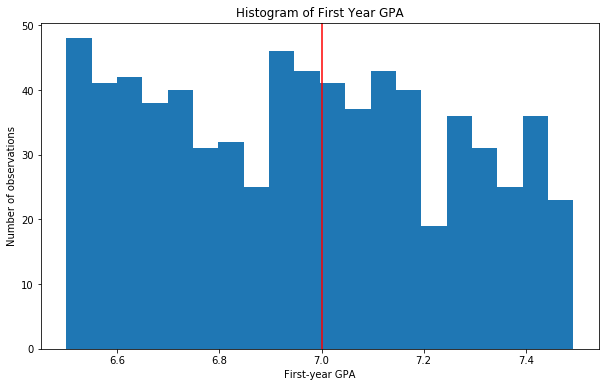

In [9]:
### frequencies of first-year GPAs

plot_gpahisto(df3,20)

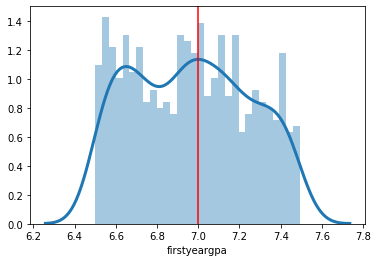

In [10]:
### Kernel distribution estimation

sns.distplot(df3["firstyeargpa"], hist=True, kde=True,bins=30,  kde_kws={'linewidth': 3})
plt.axvline(7, 0,2.5,color="red")

**Replication of Figure 2**

The last graph to check the continuity assumption was created with the "rddensity" package in R. This graph has been imported as an image, but the code can be found in the ["R_magic"](https://github.com/OpenSourceEconomics/ose-data-science-course-projeect-tihaup/blob/master/cache/R_magic.ipynb) notebook. The graph explicitely tests for a discontinuity in the density of GPA at a value of 7. This test is called McCrary Test. Since the estimated densities don't differ significantly at the cutoff, a bunching of students just above 7 can't be detected here either. 
After all, we can conclude that the validity of the continuity assumption at the cutoff seems to hold and we can discard our prior concerns that students might have certain control over treatment selection. 

![Figure 2](files/figure2.png)

### Mass Points <a name="identification3"></a>

In [11]:
### Number of observations around cutoff with optimal bandwidth

num_students = len(collect_each_student(df1))
print(f"There are {len(df1)} observations around the cutoff within the optimal bandwidth. \n")
print(f"The number of individual students is {len(collect_each_student(df1))}.")

There are 3585 observations around the cutoff within the optimal bandwidth. 

The number of individual students is 524.


Observing more than 524 individual students near the cutoff, Kapoor et al. (2020) argue that this "coverage of the support for GPA is usually sufficient for a continuity-based design".

# (4.) Replication of Baseline Results <a name="baseline"></a>

### Replication of Table 3 - Average Treatment Effects  <a name="baseline1"></a>

To get a first hint of size and direction of the effects induced by the attendance policy for below-7 students, let's have a look at the replication of Table 3. Here we pool on all three coursetypes. 
The following specifications are estimated in column 1 

\begin{align*}
G = \alpha + \tau D + \beta X + \gamma X D + \epsilon
\end{align*}

where $G$ are second-year grades, $D$ indicates treatment assignment, $X$ is the running variable $firstyeargpa$ and $X \in [6.635,7.365]$,

and in column 4

\begin{align*}
G = \alpha + \tau  D + \beta_1 X + \beta_2 X vol + \beta_3 X for + \gamma_1 X D + \gamma_2 X D vol + \gamma_3 X D for +  \epsilon 
\end{align*}

where $vol$ indicates voluntary coursetype and $for$ indicates forced coursetype.

In **column 1** we get an average treatment effect that is not signficantly different from zero, if we don't include interaction terms for different course types. Since I don't have data on personal characteristics, I cannot replicate columns 2 and 3 where fixed-effects on students' characteristics have been included. However, including these control variables does not change the result of having no average treatment effect without interaction terms.
**Column 4** in contrast includes interaction terms between treatment and coursetype. Again, the average treatment effect of all types is very close to zero and insignificant, but we get a negative estimate for the interaction term of voluntary courses with treatment. This indicates that there might be different magnitudes of effects depending on the coursetype. Figure 1 and Table 4 will show very similiar results to this first evaluation. Note that my replication of column 4 differs from the results of the paper in that the paper finds a significantly negative estimate for the treatment-voluntary interaction term.

In [12]:
### Creating interaction terms and triangular kernel weights

df11 = get_interactionterms(df1)
df111 = get_kweights(df11,0.365)
get_table3(df111)

## Heterogeneous Average Treatment Effects <a name="baseline2"></a>

### Replication of Figure 1

After observing a negative effect with an interaction term between treatment and voluntary coursetype, we now have a closer look at the differences in attendance rate and grades evaluated for each coursetype separately. The replications of Figure 1 confirm heterogeneous effects depending on the attendance policy for above-7 (untreated) students. The dots are local averages of attendance rate (left panel) and standardized grades (right panel) with a binsize of 0.05 in terms of the $firstyeargpa$ variable. The sizes of the dots represent the number of observations included in the bins and the lines are locally linear (blue) and cubic (grey) fitted regression lines. 

The large difference of attendance rates within voluntary and encouraged courses imply that the attendance rates in these courses "are higher than necessary", since we observe a negative difference of grades in voluntary courses and no effect at all in encouraged courses. For those courses where tutorial attendance was compulsary for both above-7 and below-7 students, there seems to be no effect at all. 
Kapoor et al. (2020) conclude that the "attendance and grade effects suggest grades might only decrease if the additional constraint on choices is especially severe." Later in this section we will see the exact estimates of the heterogenous treatment effects. 

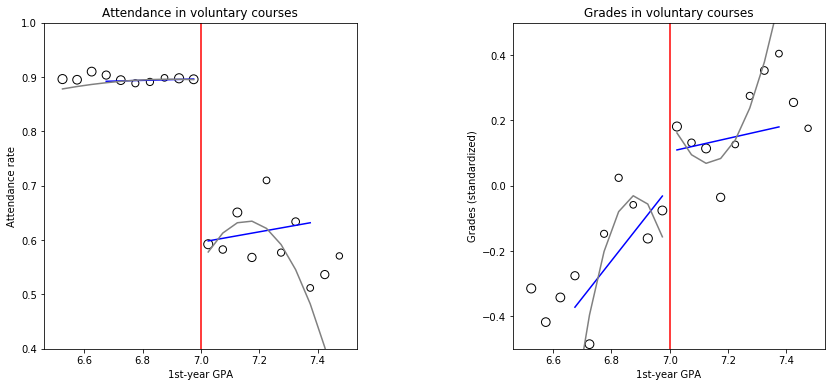

In [13]:
get_figure1(df,"voluntary")

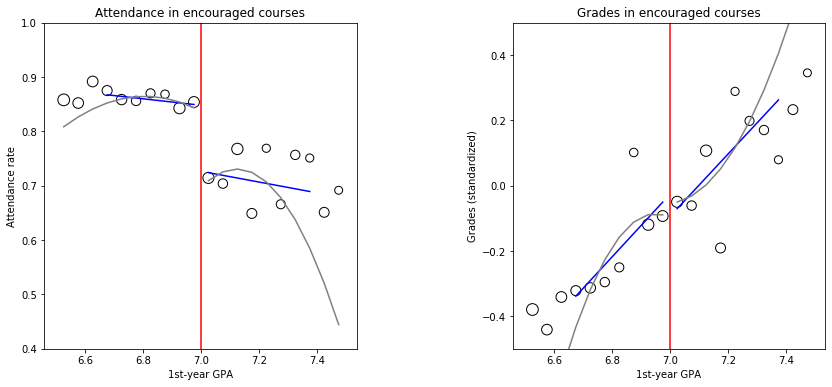

In [14]:
get_figure1(df,"encouraged")

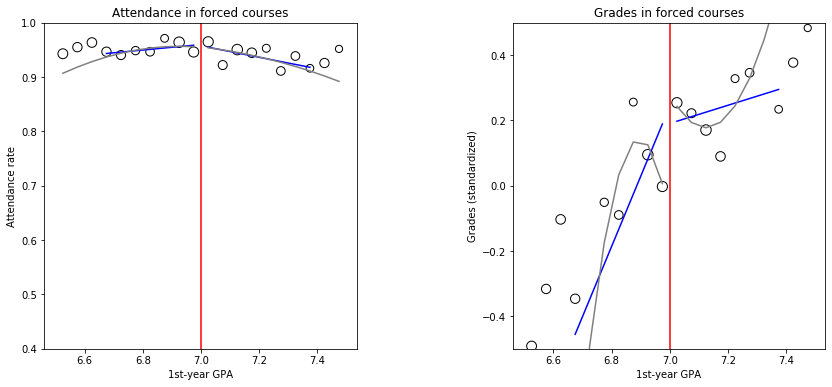

In [15]:
get_figure1(df,"forced")

### Replication of Table 4

Continuing with the results of the replicated Table 4, we can again detect some clear heterogeneity in treatment effects depending on the type of courses attended in the second year. The estimates in Table 4 have been derived from the "rdrobust" function which is implemented in R. Among other things it estimates robust bias−corrected point estimates, and therefore, calculating different treatment estimates than using OLS or Weighted Least Squares. I will conduct an independent analysis of these different estimations in chapter 6. There I will also compare these results with estimations using different degree polynomial regressions and varying the bandwidth of the data. The following specification was used: 

\begin{align*}
Y = \alpha + \tau D + \beta X + \gamma X D + \epsilon,
\end{align*}

where $Y \in \{attendance,stdgrade,passcourse\}$, $D$ indicates treatment assignment, $X$ is the running variable $firstyeargpa$ with $X \in [6.635,7.365]$. Note that we use the data group-wise for $voluntary$, $encouraged$ and $forced$ courses separately.

As we've already seen in the replication of Figure 1, the highest treatment effects can be observed within second year courses where attendance of tutorials have been made voluntary, without any penalty for absence. Here students in the treatment group have a 31% higher tutorial attendance rate and a decrease in grades. Both results for this subgroup are highly significant.
The difference between treated and untreated students within courses where tutorial attendance was encouraged but not penalized has decreased in magnitude compared to voluntary attendance courses, but still the attendance rates for treated students are significantly higher. Though, no significant difference in grades can be detected. 
The last part of Table 4 compares students within courses where also above-7 students where forced to attend tutorials. No significant treatment effects can be observed here, affirming the intuition of Figure 1. 
Notable is also that there is no significant effect on chances of passing the course in all three course types.

In [16]:
### Import the results from "R_magic" notebook:

vol_rslt  = pkl.load(open("./cache/vol_rslt_pkl.pkl","br"))
vol_rslt = vol_rslt.to_numpy()

In [17]:
enc_rslt  = pkl.load(open("./cache/enc_rslt_pkl.pkl","br"))
enc_rslt = enc_rslt.to_numpy()

In [18]:
for_rslt  = pkl.load(open("./cache/for_rslt_pkl.pkl","br"))
for_rslt = for_rslt.to_numpy()

**Table 4 - voluntary course type**

In [19]:
get_table4(vol_rslt,"voluntary")

Table 4 - voluntary course type
╒══════════════════════╤════════════════════╤════════════════╤═══════════╤════════════════╕
│ Variable             │ Treatment Effect   │ Stand. Error   │ p-value   │ Observations   │
╞══════════════════════╪════════════════════╪════════════════╪═══════════╪════════════════╡
│ Attendance rate      │                    │                │           │                │
├──────────────────────┼────────────────────┼────────────────┼───────────┼────────────────┤
│ 1st-year GPA below 7 │ 0.312              │ 0.038          │ 0.0       │ 927.0          │
├──────────────────────┼────────────────────┼────────────────┼───────────┼────────────────┤
│                      │                    │                │           │                │
├──────────────────────┼────────────────────┼────────────────┼───────────┼────────────────┤
│ Grade (standardized) │                    │                │           │                │
├──────────────────────┼────────────────────┼───

**Table 4 - encouraged course type**

In [20]:
get_table4(enc_rslt,"encouraged")

Table 4 - encouraged course type
╒══════════════════════╤════════════════════╤════════════════╤═══════════╤════════════════╕
│ Variable             │ Treatment Effect   │ Stand. Error   │ p-value   │ Observations   │
╞══════════════════════╪════════════════════╪════════════════╪═══════════╪════════════════╡
│ Attendance rate      │                    │                │           │                │
├──────────────────────┼────────────────────┼────────────────┼───────────┼────────────────┤
│ 1st-year GPA below 7 │ 0.129              │ 0.032          │ 0.0       │ 1424.0         │
├──────────────────────┼────────────────────┼────────────────┼───────────┼────────────────┤
│                      │                    │                │           │                │
├──────────────────────┼────────────────────┼────────────────┼───────────┼────────────────┤
│ Grade (standardized) │                    │                │           │                │
├──────────────────────┼────────────────────┼──

**Table 4 - forced course type**

In [21]:
get_table4(for_rslt,"forced")

Table 4 - forced course type
╒══════════════════════╤════════════════════╤════════════════╤═══════════╤════════════════╕
│ Variable             │ Treatment Effect   │ Stand. Error   │ p-value   │ Observations   │
╞══════════════════════╪════════════════════╪════════════════╪═══════════╪════════════════╡
│ Attendance rate      │                    │                │           │                │
├──────────────────────┼────────────────────┼────────────────┼───────────┼────────────────┤
│ 1st-year GPA below 7 │ 0.002              │ 0.013          │ 0.865     │ 1234.0         │
├──────────────────────┼────────────────────┼────────────────┼───────────┼────────────────┤
│                      │                    │                │           │                │
├──────────────────────┼────────────────────┼────────────────┼───────────┼────────────────┤
│ Grade (standardized) │                    │                │           │                │
├──────────────────────┼────────────────────┼──────

# (5.) Robustness Checks <a name="robustness"></a>


## Replication of Table 5 - Robustness Check with Abolition Cohort  <a name="robustness1"></a>

The abolition cohort is the first cohort that has not been affected by the attendance policy for below-7 students, since this policy was abolished in 2014.
In the replicated Table 5 the abolition cohort is compared with the previous five cohorts where below-7 students received the treatment of forced tutorial attendance. Note that we only focus on courses where above-7 students had a voluntary tutorial attendance policy and on students within a bandwidth of 0.1 around a first-year GPA of 7. 

Even when restricting the data to 0.1 around the cutoff, the difference in grades between treated and untreated students in the first five cohorts is higly significant. Whereas this difference within the abolition cohort gets very small and statistically insignifcant. We can also note that the difference across treated and abolition cohorts for both below-7 and above-7 students are not statistically significant. 
Furthermore, the replication of Table A.6 that can be found in the Appendix shows that the Treatment Effect on standardized grades is insignificant within all coursetypes in the abolition cohort. My extension, visualizing the treatment effect, shows that within voluntary courses there seems to be a small difference at the cutoff which is not significantly negative as seen in Table A.6.  

In [22]:
### get subsets of different cohorts (1-5 and 6) and only "voluntary" coursetype:

df_c15 = get_truncated_data(df,0.365,1,"voluntary")
df_c6 = get_truncated_data(df,0.365,6,"voluntary")

**Replication of Table 5 - Comparison to Abolition Cohort**

In [23]:
get_table5(df_c15,df_c6)

╒════════════════════════════════╤═════════════╤═════════════╤══════════════╤═══════════╕
│ Cohort   |   First-year GPA:   │ [6.9,7.0]   │ [7.0,7.1]   │ Difference   │ p-value   │
╞════════════════════════════════╪═════════════╪═════════════╪══════════════╪═══════════╡
│ 2009-2013                      │             │             │              │           │
├────────────────────────────────┼─────────────┼─────────────┼──────────────┼───────────┤
│ Second-year Grade Average      │ 6.404       │ 6.762       │ 0.358        │ 0.004     │
├────────────────────────────────┼─────────────┼─────────────┼──────────────┼───────────┤
│ Observations                   │ 161         │ 146         │              │           │
├────────────────────────────────┼─────────────┼─────────────┼──────────────┼───────────┤
│                                │             │             │              │           │
├────────────────────────────────┼─────────────┼─────────────┼──────────────┼───────────┤
│ 2014    

**Replication of Table A.6 (Appendix)**

In [24]:
get_table_A6(df)

╒═══════════════╤════════════════════╤══════════════════╤═══════════╤════════════════╕
│ Course Type   │   Treatment Effect │   Standard Error │   p-value │   Observations │
╞═══════════════╪════════════════════╪══════════════════╪═══════════╪════════════════╡
│ Voluntary     │             -0.112 │            0.229 │     0.627 │            279 │
├───────────────┼────────────────────┼──────────────────┼───────────┼────────────────┤
│ Encouraged    │             -0.04  │            0.189 │     0.832 │            430 │
├───────────────┼────────────────────┼──────────────────┼───────────┼────────────────┤
│ Forced        │             -0.057 │            0.163 │     0.728 │            425 │
╘═══════════════╧════════════════════╧══════════════════╧═══════════╧════════════════╛


**Extension - Visualisation of Treatment Effect in Abolition Cohort**

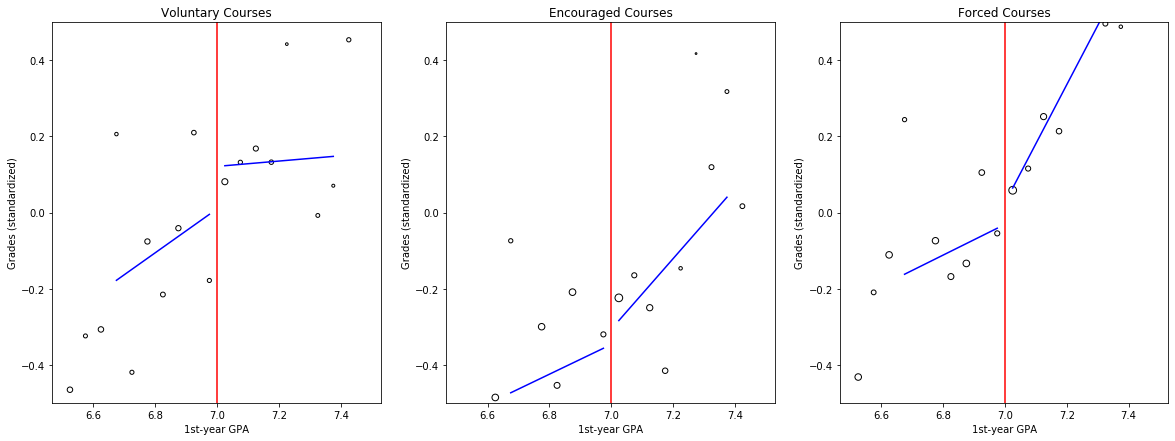

In [25]:
get_figure1_abolition(df,"voluntary")

## Other possible Mechanisms that might explain this negative treatment effect!  <a name="robustness2"></a>

**Tutorial Quality**

One possible explanation for the strong effect of lower grades within the treatment group in voluntary courses could be that there is some significant difference in tutorial quality compared to the encouraged and forced courses. Having relatively less competent Teaching Assistance in voluntary courses would then explain why students in these courses perform worse if they are forced to visit these tutorials by the attendance policy. If this mechanism were to hold true, then the impact in voluntary courses would be even higher, since the difference in attendance rate is particular high in these courses. Kapoor et al.(2020) find no significant difference in the evaluation of Teaching Assistances, but only taking into account the abolition cohort. It would be interesting to know if there are structural differences within the treated cohorts though.  

**Cost of Tutorial Attendance**

There might be costs of some sort in order to attend tutorials and these costs could differ significantly across course types, which again could explain the particular high difference in voluntary courses. Kapoor et al.(2020) use "distance to the university as a proxy for the price of attendance" since higher distances to university mean longer travel times and are therefore more costly in terms of time. Estimating treatment effects using propensity scores they find that "the policy had a larger effect on students who live far from campus", indicating that students that live farther away "have a greater propensity to attend less in the absence of forced attendance". Still, Table 6 in Kapoor et al. (2020), which I unfortunately cannot replicate again (because the author's could not provide me with the complete data set), shows that the heterogenous treatment effects across course types are very similiar to the ones estimated in the replication of Table 4.  

Since all of these possible drivers of a negative treatment effect seem to be insignificant, Kapoor et al. (2020) conclude that instead the main reason for the decrease in grades within the treatment group might be constraints on choices that students would have in the absence of this policy, and that this negative effect seems to even outweigh the positive impact of imposing a higher degree of structure.


## Fake Cutoff Test  <a name="fakecutoff"></a>

**Replication of Table A.11 (Appendix)**

In this section I want to test whether there are jumps at fake cutoffs of 6, 8, 8.25 and 9 within voluntary courses. 8.25 has been selected by Kapoor et al. (2020) since this GPA refers to a cum laude grade.  Note that Kapoor et al. (2020) performed this Fake Cutoff Test using additional control variables which are not available in this notebook. The first table depicts the treatment effects using local linear regressions with triangular kernel weighting and clustered standard errors. No significant effect can be observed at the cutoffs of 6, 8.25 and 9, but at 8 there seems to be a highly signficant, negative effect on grades. The second table depicts the imported results from the "R_magic" notebook using the "rdrobust" function. Note that here the effect at the fake cutoff is not signficant as in Kapoor et al. (2020). The difference between my results in python and the imported results using "rdrobust" in R will be further discussed in Chapter 6.
Overall, the results are still pretty close to the ones in the paper where no significant discontinuities at the fake cutoffs can be observed. This statement holds also true for the third and forth table where the effects were estimated for attendance rate and passcourse.

**Standardized Grades - Voluntary Courses**

In [26]:
rslt_fake = get_fakecutoff(df,"voluntary","stdgrade")
get_table_fakecutoff(rslt_fake)

╒══════════════════╤════════════════════╤═══════════╕
│   Fake Cutoff at │   Treatment Effect │   p-value │
╞══════════════════╪════════════════════╪═══════════╡
│             6    │              0.206 │     0.353 │
├──────────────────┼────────────────────┼───────────┤
│             8    │             -0.359 │     0.023 │
├──────────────────┼────────────────────┼───────────┤
│             8.25 │              0.114 │     0.423 │
├──────────────────┼────────────────────┼───────────┤
│             9    │              0.122 │     0.767 │
╘══════════════════╧════════════════════╧═══════════╛


**Standardized Grades - Voluntary Courses (using rdrobust)**

In [27]:
rslt_fake_r  = pkl.load(open("./cache/rslt_fake_r_pkl.pkl","br"))
get_table_fakecutoff(rslt_fake_r)

╒══════════════════╤════════════════════╤═══════════╕
│   Fake Cutoff at │   Treatment Effect │   p-value │
╞══════════════════╪════════════════════╪═══════════╡
│             6    │              0.133 │     0.494 │
├──────────────────┼────────────────────┼───────────┤
│             8    │             -0.209 │     0.211 │
├──────────────────┼────────────────────┼───────────┤
│             8.25 │              0.092 │     0.507 │
├──────────────────┼────────────────────┼───────────┤
│             9    │              0.133 │     0.772 │
╘══════════════════╧════════════════════╧═══════════╛


**Attendance Rate - Voluntary Courses**

In [28]:
rslt_fake2 = get_fakecutoff(df,"voluntary","attendance")
get_table_fakecutoff(rslt_fake2)

╒══════════════════╤════════════════════╤═══════════╕
│   Fake Cutoff at │   Treatment Effect │   p-value │
╞══════════════════╪════════════════════╪═══════════╡
│             6    │              0.019 │     0.251 │
├──────────────────┼────────────────────┼───────────┤
│             8    │              0.066 │     0.482 │
├──────────────────┼────────────────────┼───────────┤
│             8.25 │             -0.038 │     0.699 │
├──────────────────┼────────────────────┼───────────┤
│             9    │              0.24  │     0.516 │
╘══════════════════╧════════════════════╧═══════════╛


**Passcourse - Voluntary Courses**

In [29]:
rslt_fake3 = get_fakecutoff(df,"voluntary","passcourse")
get_table_fakecutoff(rslt_fake3)

╒══════════════════╤════════════════════╤═══════════╕
│   Fake Cutoff at │   Treatment Effect │   p-value │
╞══════════════════╪════════════════════╪═══════════╡
│             6    │              0.146 │     0.258 │
├──────────────────┼────────────────────┼───────────┤
│             8    │             -0.022 │     0.355 │
├──────────────────┼────────────────────┼───────────┤
│             8.25 │              0.004 │     0.333 │
├──────────────────┼────────────────────┼───────────┤
│             9    │              0     │     0.65  │
╘══════════════════╧════════════════════╧═══════════╛


# (6.) Independent Contributions  <a name="independent"></a>

In this chapter I will present my independent contributions to the paper. First, I will show my treatment effect results compared to the ones estimated in Chapter 4, using the "rdrobust" function in the "R_magic" notebook. Second, I will discuss estimations using higher degree polynomial regressions and how these results have changed. Third, I will check the sensitivity of the results to the selection of different bandwidths. 

## Specification 1 - Local Linear Regression Estimates <a name="contribution1"></a>

When first trying to replicate the baseline results of this paper I did not use the R implementation of "rdroust", but instead simply estimated the Local Average Treatment Effects using local linear regressions with triangular kernel weights and clustered standard errors. Nevertheless, my results differed by quite a bit compared to the estimates in the paper. That's why I decided to report these results and label them as my independent contribution. The specification is the same as for the replication of Table 4 without using "rdrobust":

\begin{align*}
Y = \alpha + \tau D + \beta X + \gamma X D + \epsilon,
\end{align*}

where $Y \in \{attendance,stdgrade,passcourse\}$, $D$ indicates treatment assignment, $X$ is the running variable $firstyeargpa$ with $X \in [6.635,7.365]$.

Overall the results using local linear regression estimates with triangular kernel weighting and clustered students standard errors don't differ by much compared to the ones estimated by the "rdrobust" function in R. Though, sometimes there is quite a difference in p-values, resulting from different standard errors. The main difference can be seen in the specification with voluntary courses. There the treatment effect on standardized grades differs significantly. While the specifiction in R (and in Kapoor et al. (2020)) shows a significant, negative effect on grades, my specification indeed shows a negative effect as well, that is very small though and not significant at all. That was actually the reason why I decided to run the "rdrobust" specification in the replication part, since this result was one of the main ones in the paper. This big difference might stem from the fact that the "rdrobust" function "allows for covariate-adjusted point estimation and covariate-adjusted robust bias-corrected inference" (Calonico et al.(2017)). However, I'm wondering why there is this large difference in estimations only for standardized grades around the cutoff. As seen in my first result of the Fake Cutoff Test, there has been detected a significant discontinuity at a value of 8, that should not occur there. Maybe there is some misspecification somewhere in my python code, but I've used the exact same data set here and in the "R_magic" notebook.

**Voluntary Courses**

In [30]:
get_table_spec1(df,"voluntary",vol_rslt)

╒═════════════════════╤════════════════════╤═══════════╤═══════════════════════════════╤═══════════╕
│ Variable            │   Treatment Effect │   p-value │   Treatment Effect (rdrobust) │   p-value │
╞═════════════════════╪════════════════════╪═══════════╪═══════════════════════════════╪═══════════╡
│ Attendance Rate     │              0.301 │     0     │                         0.312 │     0     │
├─────────────────────┼────────────────────┼───────────┼───────────────────────────────┼───────────┤
│ Standardized Grades │             -0.051 │     0.603 │                        -0.18  │     0.083 │
├─────────────────────┼────────────────────┼───────────┼───────────────────────────────┼───────────┤
│ Passes Course       │             -0.048 │     0.256 │                        -0.072 │     0.107 │
╘═════════════════════╧════════════════════╧═══════════╧═══════════════════════════════╧═══════════╛


**Encouraged Courses**

In [31]:
get_table_spec1(df,"encouraged",enc_rslt)

╒═════════════════════╤════════════════════╤═══════════╤═══════════════════════════════╤═══════════╕
│ Variable            │   Treatment Effect │   p-value │   Treatment Effect (rdrobust) │   p-value │
╞═════════════════════╪════════════════════╪═══════════╪═══════════════════════════════╪═══════════╡
│ Attendance Rate     │              0.137 │     0     │                         0.129 │     0     │
├─────────────────────┼────────────────────┼───────────┼───────────────────────────────┼───────────┤
│ Standardized Grades │              0.05  │     0.597 │                         0.037 │     0.714 │
├─────────────────────┼────────────────────┼───────────┼───────────────────────────────┼───────────┤
│ Passes Course       │              0.008 │     0.851 │                         0.01  │     0.819 │
╘═════════════════════╧════════════════════╧═══════════╧═══════════════════════════════╧═══════════╛


**Forced Courses**

In [32]:
get_table_spec1(df,"forced",for_rslt)

╒═════════════════════╤════════════════════╤═══════════╤═══════════════════════════════╤═══════════╕
│ Variable            │   Treatment Effect │   p-value │   Treatment Effect (rdrobust) │   p-value │
╞═════════════════════╪════════════════════╪═══════════╪═══════════════════════════════╪═══════════╡
│ Attendance Rate     │              0.004 │      0.77 │                         0.002 │     0.865 │
├─────────────────────┼────────────────────┼───────────┼───────────────────────────────┼───────────┤
│ Standardized Grades │              0.063 │      0.54 │                        -0.034 │     0.735 │
├─────────────────────┼────────────────────┼───────────┼───────────────────────────────┼───────────┤
│ Passes Course       │              0.003 │      0.93 │                        -0.033 │     0.348 │
╘═════════════════════╧════════════════════╧═══════════╧═══════════════════════════════╧═══════════╛


## Specification 2 - Local Polynomial Regression Estimates <a name="contribution2"></a>

As a second part of my independent contribution I compare the previous results with estimates of local regressions using higher degree polynomials. In order to not overload this notebook with imported results using the "rdrobust" function, I estimated the treatment effects using Weighted Least Squares Regression with triangular kernel weights and clustered standard errors. The following specifications have been considered in the analysis:

**Local Quadratic Regression Estimates**

\begin{align*}
G = \alpha + \tau D + \beta_1 X + \beta_2 X^2 + \gamma_1 X D + \gamma_2 X^2 D + \epsilon,
\end{align*}

**Local Cubic Regression Estimates**

\begin{align*}
G = \alpha + \tau D + \beta_1 X + \beta_2 X^2 + \beta_3 X^3 + \gamma X D + \gamma_2 X^2 D + \gamma_3 X^3 D + \epsilon,
\end{align*}

where $G$ are standardized second-year grades, $D$ indicates treatment assignment and $X$ is the running variable $firstyeargpa$ with $X \in [6.635,7.365]$

Since we are particularly interested in the effects on grades, I conducted the following analysis only on standardized grades. The first table shows the treatment effects within voluntary courses. Here the treatment effect on grades increases by a lot and becomes highly significant in the quadratic and cubic specification. Again, the big difference of the linear specification compared to the results with "rdrobust" have been discussed earlier, and that's also the reason why the difference here is pretty large. In the second table there is almost no difference between the three specifications observable. The third table shows that the treatment effect in forced courses becomes negative and significant in the cubic specification. Having another look at the replicated Figure 4 where the grey line is actually a cubic fitted line (bandwidth of 0.5, though) it can be observed that there is quite a difference right at the cutoff. Notable is that the treatment effect even becomes larger than within voluntary courses.

**Voluntary Courses**

In [33]:
get_table_spec2(df,"voluntary")

╒═══════════════════════╤════════════════════╤═══════════╕
│ Order of Polynomial   │   Treatment Effect │   p-value │
╞═══════════════════════╪════════════════════╪═══════════╡
│ Locally Linear        │         -0.0514075 │ 0.603373  │
├───────────────────────┼────────────────────┼───────────┤
│ Locally Quadratic     │         -0.38113   │ 0.0103801 │
├───────────────────────┼────────────────────┼───────────┤
│ Locally Cubic         │         -0.338567  │ 0.0954151 │
╘═══════════════════════╧════════════════════╧═══════════╛


**Encouraged Courses**

In [34]:
get_table_spec2(df,"encouraged")

╒═══════════════════════╤════════════════════╤═══════════╕
│ Order of Polynomial   │   Treatment Effect │   p-value │
╞═══════════════════════╪════════════════════╪═══════════╡
│ Locally Linear        │         0.0501446  │  0.596693 │
├───────────────────────┼────────────────────┼───────────┤
│ Locally Quadratic     │         0.00922801 │  0.948404 │
├───────────────────────┼────────────────────┼───────────┤
│ Locally Cubic         │        -0.0691085  │  0.711651 │
╘═══════════════════════╧════════════════════╧═══════════╛


**Forced Courses**

In [35]:
get_table_spec2(df,"forced")

╒═══════════════════════╤════════════════════╤═══════════╕
│ Order of Polynomial   │   Treatment Effect │   p-value │
╞═══════════════════════╪════════════════════╪═══════════╡
│ Locally Linear        │          0.0629805 │ 0.539971  │
├───────────────────────┼────────────────────┼───────────┤
│ Locally Quadratic     │         -0.185706  │ 0.204558  │
├───────────────────────┼────────────────────┼───────────┤
│ Locally Cubic         │         -0.483509  │ 0.0180783 │
╘═══════════════════════╧════════════════════╧═══════════╛


## Specification 3 - Bandwidth Sensitivity <a name="contribution3"></a>

As a final contribution I vary the selected bandwidth of data considered in the estimations and will compare the results to the optimal bandwidth of 0.365 that was chosen by Kapoor et al. (2020). The first three tables show the results of the sensitivity analysis within voluntary courses only. We can observe pretty robust results for attendance rate and passcourse compared to the results of the optimal bandwidth. For standardized grades we can observe that the further we restrict the data towards the cutoff the higher negative the treatment effect on grades, which even becomes highly significant at a bandwidth of 0.2. 

**Attendance Rate - Voluntary Courses**   

In [36]:
rslt_bw1 = get_bandwidth_results(df,"voluntary","attendance")
get_table_spec3(rslt_bw1)

╒═════════════╤════════════════════╤═══════════╕
│   Bandwidth │   Treatment Effect │   p-value │
╞═════════════╪════════════════════╪═══════════╡
│       0.5   │              0.27  │         0 │
├─────────────┼────────────────────┼───────────┤
│       0.4   │              0.278 │         0 │
├─────────────┼────────────────────┼───────────┤
│       0.365 │              0.301 │         0 │
├─────────────┼────────────────────┼───────────┤
│       0.3   │              0.301 │         0 │
├─────────────┼────────────────────┼───────────┤
│       0.2   │              0.312 │         0 │
├─────────────┼────────────────────┼───────────┤
│       0.1   │              0.343 │         0 │
╘═════════════╧════════════════════╧═══════════╛


**Standardized Grades - Voluntary Courses**  

In [37]:
rslt_bw2 = get_bandwidth_results(df,"voluntary","stdgrade")
get_table_spec3(rslt_bw2)

╒═════════════╤════════════════════╤═══════════╕
│   Bandwidth │   Treatment Effect │   p-value │
╞═════════════╪════════════════════╪═══════════╡
│       0.5   │             -0.141 │     0.112 │
├─────────────┼────────────────────┼───────────┤
│       0.4   │             -0.08  │     0.403 │
├─────────────┼────────────────────┼───────────┤
│       0.365 │             -0.051 │     0.603 │
├─────────────┼────────────────────┼───────────┤
│       0.3   │             -0.108 │     0.321 │
├─────────────┼────────────────────┼───────────┤
│       0.2   │             -0.352 │     0.008 │
├─────────────┼────────────────────┼───────────┤
│       0.1   │             -0.344 │     0.06  │
╘═════════════╧════════════════════╧═══════════╛


**Passes Course - Voluntary Courses**  

In [38]:
rslt_bw3 = get_bandwidth_results(df,"voluntary","passcourse")
get_table_spec3(rslt_bw3)

╒═════════════╤════════════════════╤═══════════╕
│   Bandwidth │   Treatment Effect │   p-value │
╞═════════════╪════════════════════╪═══════════╡
│       0.5   │             -0.065 │     0.089 │
├─────────────┼────────────────────┼───────────┤
│       0.4   │             -0.057 │     0.161 │
├─────────────┼────────────────────┼───────────┤
│       0.365 │             -0.048 │     0.256 │
├─────────────┼────────────────────┼───────────┤
│       0.3   │             -0.039 │     0.409 │
├─────────────┼────────────────────┼───────────┤
│       0.2   │             -0.119 │     0.041 │
├─────────────┼────────────────────┼───────────┤
│       0.1   │             -0.095 │     0.233 │
╘═════════════╧════════════════════╧═══════════╛


Interesting is the comparison of standardized grades in encouraged and forced courses. While the effect in encouraged courses stays very close to zero throughout the selection of bandwidths, the effect in forced courses, where we observed the smallest difference between treated and untreated students in all of the previous analyses, becomes significant and highly negative if we reach a bandwidth of 0.1 around the cutoff.   

**Standardized Grades - Encouraged Courses**

In [39]:
rslt_bw4 = get_bandwidth_results(df,"encouraged","stdgrade")
get_table_spec3(rslt_bw4)

╒═════════════╤════════════════════╤═══════════╕
│   Bandwidth │   Treatment Effect │   p-value │
╞═════════════╪════════════════════╪═══════════╡
│       0.5   │              0.035 │     0.673 │
├─────────────┼────────────────────┼───────────┤
│       0.4   │              0.032 │     0.721 │
├─────────────┼────────────────────┼───────────┤
│       0.365 │              0.05  │     0.597 │
├─────────────┼────────────────────┼───────────┤
│       0.3   │              0.068 │     0.513 │
├─────────────┼────────────────────┼───────────┤
│       0.2   │             -0.069 │     0.584 │
├─────────────┼────────────────────┼───────────┤
│       0.1   │             -0.02  │     0.908 │
╘═════════════╧════════════════════╧═══════════╛


**Standardized Grades - Forced Courses**

In [40]:
rslt_bw5 = get_bandwidth_results(df,"forced","stdgrade")
get_table_spec3(rslt_bw5)

╒═════════════╤════════════════════╤═══════════╕
│   Bandwidth │   Treatment Effect │   p-value │
╞═════════════╪════════════════════╪═══════════╡
│       0.5   │             -0.027 │     0.769 │
├─────────────┼────────────────────┼───────────┤
│       0.4   │             -0.025 │     0.8   │
├─────────────┼────────────────────┼───────────┤
│       0.365 │              0.063 │     0.54  │
├─────────────┼────────────────────┼───────────┤
│       0.3   │              0.052 │     0.638 │
├─────────────┼────────────────────┼───────────┤
│       0.2   │             -0.162 │     0.216 │
├─────────────┼────────────────────┼───────────┤
│       0.1   │             -0.291 │     0.099 │
╘═════════════╧════════════════════╧═══════════╛


Finally, I compare the effect of the selected bandwidth between the linear, quadratic and cubic specification within voluntary courses and only on standardized grades. One can see that in contrast to the linear specification where the treatment effect becomes highly signficant, even in my non-robust specification, the effects in the quadratic and cubic specification become smaller and insignificant the smaller the selected bandwidth. 

In [41]:
### Quadratic and Cubic Bandwidth Results

rslt_bw_quad = get_bandwidth_results2(df,"voluntary","stdgrade") 
rslt_bw_cub = get_bandwidth_results3(df,"voluntary","stdgrade")

In [42]:
get_table_spec3_comparison(rslt_bw2, rslt_bw_quad, rslt_bw_cub)

╒═════════════╤═══════════════════╤═══════════╤══════════════════════╤═══════════╤══════════════════╤═══════════╕
│   Bandwidth │   Effect (linear) │   p-value │   Effect (quadratic) │   p-value │   Effect (cubic) │   p-value │
╞═════════════╪═══════════════════╪═══════════╪══════════════════════╪═══════════╪══════════════════╪═══════════╡
│       0.5   │            -0.141 │     0.112 │               -0.114 │     0.367 │           -0.424 │     0.015 │
├─────────────┼───────────────────┼───────────┼──────────────────────┼───────────┼──────────────────┼───────────┤
│       0.4   │            -0.08  │     0.403 │               -0.269 │     0.056 │           -0.431 │     0.026 │
├─────────────┼───────────────────┼───────────┼──────────────────────┼───────────┼──────────────────┼───────────┤
│       0.365 │            -0.051 │     0.603 │               -0.381 │     0.01  │           -0.339 │     0.095 │
├─────────────┼───────────────────┼───────────┼──────────────────────┼───────────┼──────

# (7.) Conclusion/Discussion <a name="conclusion"></a>

All in all I find similiar results compared to Kapoor et al. (2020), especially when I use the "rdrobust" function. I found a strikingly different result regarding the treatment effect on grades using local linear regression estimates which might be explained by the characteristics of the "rdrobust" function which  "allows for covariate-adjusted point estimation and covariate-adjusted robust bias-corrected inference" (Calonico et al.(2017)). 

Nevertheless, even considering my weaker result of having no treatment effect on second-year grades within voluntary courses, the implementation or success of this forced attendance policy is very questionable and was abolished in 2014 after all. The negative effect of constraining the independent choice of study input seems to outweigh the positive effect of giving additional structure to students. These findings of Kapoor et al. (2020) are in conflict with other papers on the topic of mandatory tutorial sessions in the field of Education Economics. In stark contrast are the results of Dobkin et al. (2010) that find a significant positive treatment effect on grades using RDD as well. Though, their attendance policy differed in that treatment of forced attendance was assigned course-wise and already after the midterm exams and only for the remaining semester. Therefore, one could argue that the induced costs of forced tutorial attendance were not as severe as in Kapoor et al. (2020). Overall, the findings of Kapoor et al. (2020) show that the effect of additional structure in university programs is not as obvious as expected and leads itself to further empirical work. One parameter one might change in future studies is the severeness of forced tutorials. 

# (8.) References <a name="references"></a>

* **Calconico, Cattaneo & Farrel (2017).** rdrobust: Software for regression-discontinuity designs. The Stata Journal (17, Number 2, pp. 372–404).


* **Cunningham (2021).** Causal Inference: The Mixtape. Yale University Press.


* **Dobkin, Gil & Marion (2010).** Skipping Class in College and Exam Performance: Evidence from a Regression Discontinuity Classroom Experiment. Economics of Education Review (Volume 29, Issue 4, pp. 566-575).


* **Kapoor, Oosterveen & Webbink (2020).** The Price of Forced Attendance. Journal of Applied Econometrics (Volume 36, Issue 2, pp. 209-227). 